# Pregunta 1:
## ¿Se pueden predecir las características de las matrículas para años futuros considerando los datos actuales?

#### Para responder esta pregunta, se deben completar dos pasos previos. 

#### *Primero*, generar Clustering con ciertos atributos seleccionados gracias a la exploración realizada en el hito 1. Con esto, y la correspondiente validación del clustering, podremos cuantificar potenciales patrones de agrupación. 

#### *Segundo*, una vez sabiendo esto, podremos vectorizar las instancias, de forma que facilite su manejo en algortimos de Regresión.

¿Cuáles son las caracteristicas de las matrículas?
- Caracteristicas de matriculaciones de estudiantes (centrada en instancias)?
    - qué carrera
    - primera carrera?
    - dónde se matricula?
    - esta acreditada?
    - se cambia de institución?
        - de nombre?
        - de tipo?
    - se cambia de area del conocimineto?
    - se cambia de región?
- Su número?
- Su distribución nacional?

In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

path_to_2015 = "../Data/2015.csv" # Hay que agregar el de cada uno.
df = pd.read_csv(path_to_2015) #nrows=100)

In [17]:
print(df.shape)
df.iloc[10:20]

(1233043, 47)


,cat_periodo,codigo_unico,MRUN,GEN_ALU,FEC_NAC_ALU,rango_edad,anio_ing_carr_ori,sem_ing_carr_ori,anio_ing_carr_act,sem_ing_carr_act,...,area_conocimiento,cine_f_13_area,cine_f_13_subarea,area_carrera_generica,acreditada_carr,acreditada_inst,acre_inst_desde_hasta,acre_inst_anio,costo_proceso_titulacion,costo_obtencion_titulo_diploma
10,2015,I16S27C27J2V1,NaN,2,198303.0,30 a 34 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
11,2015,I16S27C27J2V1,NaN,2,198612.0,25 a 29 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
12,2015,I16S27C27J2V1,NaN,1,198612.0,25 a 29 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
13,2015,I16S27C27J2V1,NaN,2,198807.0,25 a 29 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
14,2015,I16S27C27J2V1,NaN,2,198506.0,30 a 34 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
15,2015,I16S27C27J2V1,NaN,1,198907.0,25 a 29 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
16,2015,I16S27C27J2V1,NaN,2,198411.0,30 a 34 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
17,2015,I16S27C27J2V1,NaN,2,198507.0,25 a 29 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
18,2015,I16S27C27J2V1,NaN,2,197912.0,35 a 39 años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000
19,2015,I16S27C27J2V1,NaN,1,196303.0,40 y más años,9999,1,2013.0,1.0,...,Administración y Comercio,Administración de Empresas y Derecho,Educación Comercial y Administración,Ingeniería Comercial,NO ACREDITADA,NO ACREDITADA,NaN,NaN,203500,305000


#### Es necesario destacar que, a pesar de que el dataset posee abundantes atributos, como ya se dijo en el hito uno, muchos de estos pueden tienen relación directa con otros, agregado a esto, en su gran mayoria las columnas son categoricas y poseen pocas clases (o derechamente son binarias). Afortunadamente, esto se compensa con la cantidad de instancias en el dataset, del orden de millones. Con esto podemos suponer (a priori) una caracterización lo suficientemente funcional.

Seleccionamos las columnas  en orden de aparición (selección para la matriz de correlación del **hito 1**): 
- `rango_edad`
- `tipo_inst_2`: Clasificación del tipo de institución
- `jornada`
- `tipo_plan_carr`: Distinción dada por el tipo plan que posee la carrera o programa.
- `region_sede`: Región de la sede.
- `nivel_carrera_2`: Tipo de grado académico entregado por la carrera.
- `requisito_ingreso` *¡Eliminada, al no estar en el dataset de cada año!
- `vigencia_carrera` *¡Eliminada, al no estar en el dataset de cada año!
- `area_conocimiento`
- `acreditada_carr`: Situación de acreditación de la carrera o programa informada por la institución al 30 de abril del año del proceso. 
- `acreditada_inst`: Situación acreditación de institución al 30 de abril del año en proceso.

También añadimos nuevos atributos que pueden ser vitales en la caracterización:
- `anio_ing_carr_ori` 
- `sem_ing_carr_ori`
- `anio_ing_carr_act`
- `sem_ing_carr_act`
(- `nomb_inst`)
(- `nomb_carrera`)
(- `dur_estudio_carr`)
(- `dur_proceso_tit`)
- `dur_total_carr`
- `valor_matricula`
- `valor_arancel`

Por lo tanto, nos quedamos con 22 de 47 columas

In [18]:
select_columns = ["rango_edad","tipo_inst_2","jornada","tipo_plan_carr","region_sede","nivel_carrera_2","requisito_ingreso", \
    "vigencia_carrera","area_conocimiento","acreditada_carr","acreditada_inst","anio_ing_carr_ori","sem_ing_carr_ori", \
    "anio_ing_carr_act","sem_ing_carr_act",\
    "dur_total_carr", \
    "valor_matricula","valor_arancel"]
select = df.loc[:, select_columns]
# Saqué "nomb_inst", "nomb_carrera", "dur_estudio_carr","dur_proceso_tit"

In [19]:
for column in select.select_dtypes('object'):
    uniques = select[column].unique()
    print(f"Valores unicos de {str(column)}: ", uniques)

Valores unicos de rango_edad:  ['20 a 24 años' '15 a 19 años' '35 a 39 años' '25 a 29 años'
 '30 a 34 años' '40 y más años' nan]
Valores unicos de tipo_inst_2:  ['Universidades Privadas' 'Universidades CRUCH' 'Institutos Profesionales'
 'Centros de Formación Técnica']
Valores unicos de jornada:  ['Diurno' 'Vespertino' 'A Distancia' 'Otro' 'Semipresencial']
Valores unicos de tipo_plan_carr:  ['Plan Regular' 'Plan Regular de Continuidad' 'Plan Especial']
Valores unicos de region_sede:  ['Metropolitana' 'Coquimbo' 'Tarapacá' 'Arica y Parinacota' 'Valparaíso'
 'Ñuble' 'Antofagasta' 'Atacama' 'Biobío' "Lib. Gral B. O'Higgins"
 'La Araucanía' 'Maule' 'Los Lagos' 'Magallanes' 'Los Ríos' 'Aysén']
Valores unicos de nivel_carrera_2:  ['Carreras Profesionales' 'Carreras Técnicas' 'Magister' 'Postítulo'
 'Doctorado']
Valores unicos de requisito_ingreso:  ['Educación Media' 'Licenciatura' nan 'Título Profesional'
 'Técnico de Nivel Superior' 'Magíster'
 'Especialidad Médica u Odontológica' 'Plan Co

#### Para las columnas con variables categoricas ordinales, se tokeniza de igual manera: en orden. Para columnas categoricas nominales, se tokeniza de forma aleatoria.

Ordinales:
- rango_edad {'15 a 19 años':1,'20 a 24 años':2, '35 a 39 años':3, '25 a 29 años':4, '30 a 34 años':5, '40 y más años':6}
- nivel_carrera_2 {'Carreras Técnicas':1, 'Carreras Profesionales':2, 'Magister':3, 'Postítulo':4, 'Doctorado':5}
- acreditada_carr {"NO ACREDITADA":0, "ACREDITADA":1}
- acreditada_inst {"NO ACREDITADA":0, "ACREDITADA":1}

#### Se creará un diccionario para cada atributo, con sus clases y codificaciones.

In [20]:
all_dict = {}
for column in select.select_dtypes('object'):
    all_dict[column] = {value:i+1 for i, value in enumerate(select[column].unique()) if value is not np.nan}

print(all_dict)
all_dict["rango_edad"] = {'15 a 19 años':1,'20 a 24 años':2, '35 a 39 años':3, '25 a 29 años':4, '30 a 34 años':5, '40 y más años':6}
all_dict["nivel_carrera_2"] = {'Carreras Técnicas':1, 'Carreras Profesionales':2, 'Magister':3, 'Postítulo':4, 'Doctorado':5}
all_dict["acreditada_carr"] = {"NO ACREDITADA":0, "ACREDITADA":1}
all_dict["acreditada_inst"] = {"NO ACREDITADA":0, "ACREDITADA":1}

{'rango_edad': {'20 a 24 años': 1, '15 a 19 años': 2, '35 a 39 años': 3, '25 a 29 años': 4, '30 a 34 años': 5, '40 y más años': 6}, 'tipo_inst_2': {'Universidades Privadas': 1, 'Universidades CRUCH': 2, 'Institutos Profesionales': 3, 'Centros de Formación Técnica': 4}, 'jornada': {'Diurno': 1, 'Vespertino': 2, 'A Distancia': 3, 'Otro': 4, 'Semipresencial': 5}, 'tipo_plan_carr': {'Plan Regular': 1, 'Plan Regular de Continuidad': 2, 'Plan Especial': 3}, 'region_sede': {'Metropolitana': 1, 'Coquimbo': 2, 'Tarapacá': 3, 'Arica y Parinacota': 4, 'Valparaíso': 5, 'Ñuble': 6, 'Antofagasta': 7, 'Atacama': 8, 'Biobío': 9, "Lib. Gral B. O'Higgins": 10, 'La Araucanía': 11, 'Maule': 12, 'Los Lagos': 13, 'Magallanes': 14, 'Los Ríos': 15, 'Aysén': 16}, 'nivel_carrera_2': {'Carreras Profesionales': 1, 'Carreras Técnicas': 2, 'Magister': 3, 'Postítulo': 4, 'Doctorado': 5}, 'requisito_ingreso': {'Educación Media': 1, 'Licenciatura': 2, 'Título Profesional': 4, 'Técnico de Nivel Superior': 5, 'Magíster'

In [21]:
for attribute in all_dict:
    select[attribute] = select[attribute].map(all_dict[attribute])
select

,rango_edad,tipo_inst_2,jornada,tipo_plan_carr,region_sede,nivel_carrera_2,requisito_ingreso,vigencia_carrera,area_conocimiento,acreditada_carr,acreditada_inst,anio_ing_carr_ori,sem_ing_carr_ori,anio_ing_carr_act,sem_ing_carr_act,dur_total_carr,valor_matricula,valor_arancel
0,2.0,1,1,1,1,2,1.0,1,1,0,1,2015,1,NaN,NaN,8,100000.0,3369000.0
1,1.0,1,2,1,1,2,1.0,1,2,1,1,2015,1,NaN,NaN,8,100000.0,2312000.0
2,2.0,1,1,1,2,2,1.0,1,1,0,0,2015,1,NaN,NaN,10,120000.0,2185000.0
3,3.0,1,2,1,2,2,1.0,1,2,0,0,2015,1,NaN,NaN,10,120000.0,1760000.0
4,2.0,1,1,1,1,2,1.0,1,3,0,1,2015,1,NaN,NaN,10,363900.0,3900530.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233038,6.0,1,5,1,1,4,4.0,2,10,0,1,2014,1,NaN,NaN,1,0.0,1327500.0
1233039,1.0,3,2,1,1,1,1.0,1,5,0,1,2015,1,NaN,NaN,7,89900.0,1489900.0
1233040,1.0,1,1,1,1,2,1.0,1,4,0,1,2015,1,NaN,NaN,10,340000.0,3590000.0
1233041,3.0,2,1,3,3,3,4.0,2,6,0,1,2013,1,NaN,NaN,6,150000.0,1166666.0


In [22]:
select.iloc[:,:-2] = select.iloc[:,:-2].convert_dtypes(np.int32)
dummies = pd.get_dummies(select, prefix=select_columns[:-2], columns=select_columns[:-2])
dummies

,valor_matricula,valor_arancel,rango_edad_1,rango_edad_2,rango_edad_3,rango_edad_4,rango_edad_5,rango_edad_6,tipo_inst_2_1,tipo_inst_2_2,...,dur_total_carr_8,dur_total_carr_9,dur_total_carr_10,dur_total_carr_11,dur_total_carr_12,dur_total_carr_13,dur_total_carr_14,dur_total_carr_16,dur_total_carr_20,dur_total_carr_24
0,100000.0,3369000.0,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,100000.0,2312000.0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,120000.0,2185000.0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,120000.0,1760000.0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,363900.0,3900530.0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233038,0.0,1327500.0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1233039,89900.0,1489900.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1233040,340000.0,3590000.0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1233041,150000.0,1166666.0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


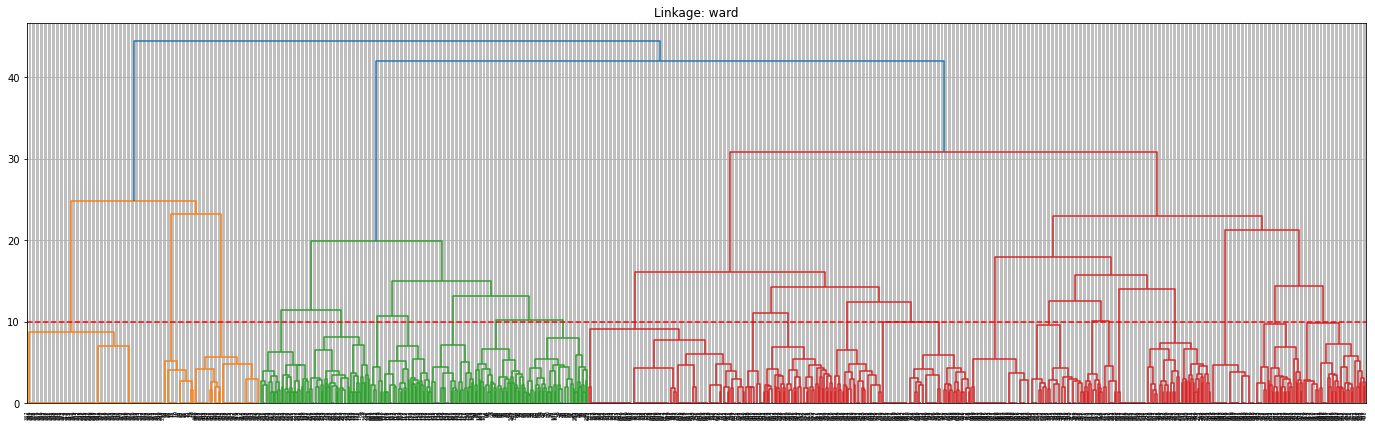

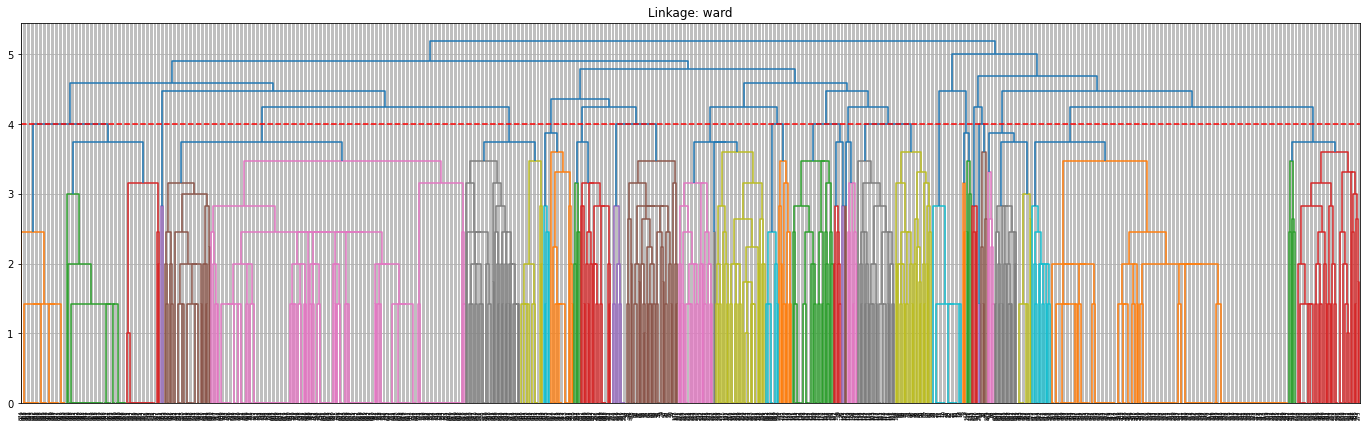

In [23]:
height = 10
ward = linkage(dummies.iloc[:1000,2:], method="ward")
fig, ax = plt.subplots(1, 1, figsize=(24,7))
dendrogram(ward, ax=ax)
plt.grid()
plt.title("Linkage: ward")
plt.axhline(y=height, color='r', linestyle='--')
plt.show()

complete = linkage(dummies.iloc[:1000,2:], method="complete")
fig, ax = plt.subplots(1, 1, figsize=(24,7))
dendrogram(complete, ax=ax)
plt.grid()
plt.title("Linkage: ward")
plt.axhline(y=4, color='r', linestyle='--')
plt.show()

Vemos que los clusters estan mejor demarcados por el método ``ward`` de clustering Jerárquico, por lo tanto, se decide ocupar para el resto del experimento.
Notamos que, por la naturaleza de las instancias; desglosadas en un One-hot general, los métodos K-means o DBSCAN no podrían ser muy efectivos caracterizando el dataset.  

In [24]:
used = 10000 # len(dummies)

Podemos reconocer una leve estructura de cluster en los datos, para el espacio One-Hot. En el caso del método PCA aplicado al espacio antes mencionado, notamos solapamiento entre clusters, aún así, en el gráfico podemos apreciacar estructuras interantes, las que posiblemente contengas información relevante.

Ahora, probamos aplicar Clustering Juerarquico a la colección de vectores **luego** de aplicar PCA.

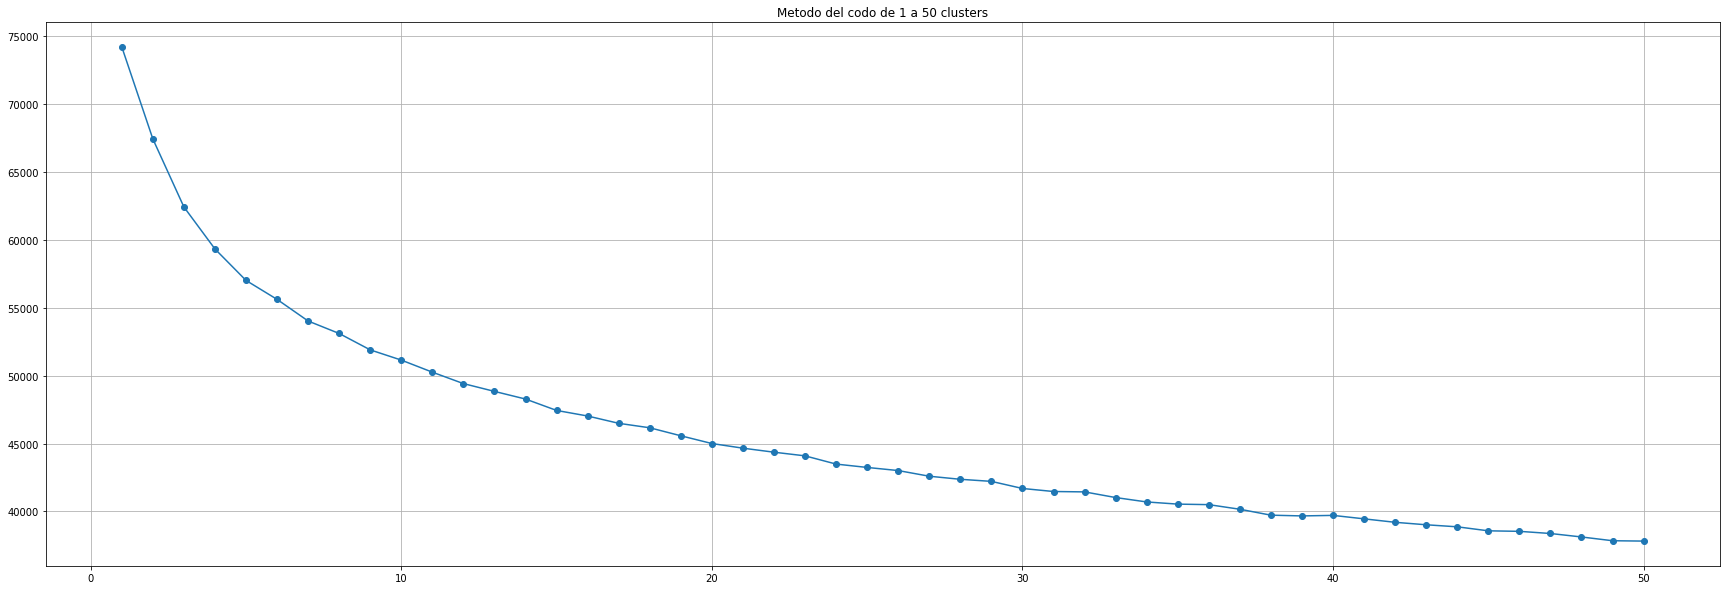

In [25]:

sse_k = []
sse_w = []
total_ = 50
clusters = list(range(1, total_+1))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(dummies.iloc[:used,2:])
    #wards = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(dummies.iloc[:used,2:])
    sse_k.append(kmeans.inertia_)
    #sse_w.append(wards.affinity)

fig, ax = plt.subplots(1,1, figsize=(30,10))
ax.plot(clusters, sse_k, "o-")
plt.title(f"Metodo del codo de 1 a {total_} clusters")
plt.grid(True)
plt.show()

20


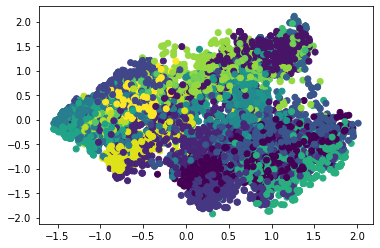

Silhouete del espacio PCA con Clusterning Jerarquico (ward)	 -0.05801003812797862
Silhouette del espacio one-hot con Clusterning Jerarquico (ward)	 0.05964943994947762


In [26]:
n_clus = 20
ward = AgglomerativeClustering(n_clusters=n_clus, linkage="ward", distance_threshold=None).fit(dummies.iloc[:used,2:])
print(ward.n_clusters_)

new_space = PCA(n_components=2, random_state=1).fit_transform(dummies.iloc[:used,2:])

plt.scatter(new_space[:, 0], new_space[:, 1], c=ward.labels_)
plt.show()

print("Silhouete del espacio PCA con Clusterning Jerarquico (ward)\t", silhouette_score(new_space, ward.labels_))
print("Silhouette del espacio one-hot con Clusterning Jerarquico (ward)\t", silhouette_score(dummies.iloc[:used,2:], ward.labels_))

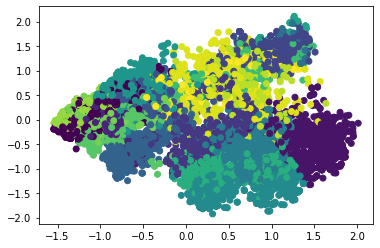

Silhouete del espacio PCA con KMeans Clustering	 0.023934520346331697
Silhouete del espacio One-hot con KMeans Clustering	 0.09104361600059412


In [27]:
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=n_clus).fit(dummies.iloc[:used,2:])

new_space = PCA(n_components=2, random_state=1).fit_transform(dummies.iloc[:used,2:])

plt.scatter(new_space[:, 0], new_space[:, 1], c=kmean.labels_)
plt.show()

print("Silhouete del espacio PCA con KMeans Clustering\t", silhouette_score(new_space, kmean.labels_))
print("Silhouete del espacio One-hot con KMeans Clustering\t", silhouette_score(dummies.iloc[:used,2:], kmean.labels_))

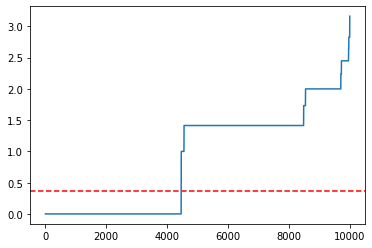

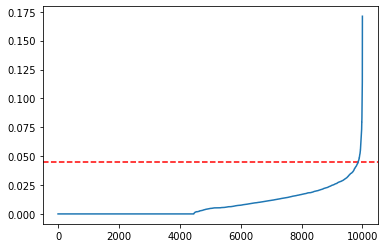

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=3).fit(dummies.iloc[:used,2:])
distances, indices = nbrs.kneighbors(dummies.iloc[:used,2:])

y_ = 0.37
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=y_, color='r', linestyle='--') #Ajuste el valor para "y" en esta línea
plt.plot(distances)
plt.show()

new_space = PCA(n_components=2, random_state=1).fit_transform(dummies.iloc[:used,2:])
nbrs = NearestNeighbors(n_neighbors=3).fit(new_space)
distances, indices = nbrs.kneighbors(new_space)

y_ = 0.045
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axhline(y=y_, color='r', linestyle='--') #Ajuste el valor para "y" en esta línea
plt.plot(distances)
plt.show()

Imposible establecer mediante el "método de la rodilla" un valor óptimo para epsilon. Esto de igual forma podría indicar que no se establecen cluster de la forma en que DBSCAN los establece.

El segundo gráfico es no concluyente, al aplicarse a una colección de vectores productos del PCA.

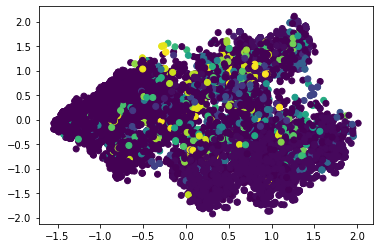

Silhouete del espacio PCA con DBSCAN Clustering	 -0.7288990506788339
Silhouete del espacio One-hot con DBSCAN Clustering	 -0.13678011620936573


In [29]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2).fit(dummies.iloc[:used,2:])

new_space = PCA(n_components=2, random_state=1).fit_transform(dummies.iloc[:used,2:])

plt.scatter(new_space[:, 0], new_space[:, 1], c=dbscan.labels_)
plt.show()

print("Silhouete del espacio PCA con DBSCAN Clustering\t", silhouette_score(new_space, dbscan.labels_))
print("Silhouete del espacio One-hot con DBSCAN Clustering\t", silhouette_score(dummies.iloc[:used,2:], dbscan.labels_))

DBSCAN no es el método de clustering indicado para el problema

El código del cuadro inferior consiste en el 

In [30]:
used = 10000
n_clus = 20
np.random.seed(10)
n_years = 10
ndims = 2
for nn in ['requisito_ingreso', 'vigencia_carrera']:
    try: select_columns.remove(nn)
    except: pass
    try: all_dict.pop(nn)
    except: pass

centroid_coord = np.zeros((n_clus, ndims, n_years))
for i in range(n_years):
    path = f"../Data/201{i}.csv" # Hay que agregar el de cada uno.
    df = pd.read_csv(path, nrows=None)
    df = df.loc[:, select_columns]
    for attribute in all_dict:
        df[attribute] = df[attribute].map(all_dict[attribute])
    df.iloc[:,:-2] = df.iloc[:,:-2].convert_dtypes(np.int32)
    df = pd.get_dummies(df, prefix=select_columns[:-2], columns=select_columns[:-2])

    print("n° de instancias: ", len(df))
    sample = np.random.choice(len(df), used)
    kmean = KMeans(n_clusters=n_clus).fit(df.iloc[sample,2:])
    centroid_coord[:, :, i] = kmean.cluster_centers_

    new_space = PCA(n_components=ndims, random_state=1).fit_transform(df.iloc[sample,2:])

    plt.scatter(new_space[:, 0], new_space[:, 1], c=kmean.labels_)
    plt.show()
    
    print("n° de instancias usadas: ", used)
    print("Silhouete del espacio PCA con KMeans Clustering\t", silhouette_score(new_space, kmean.labels_))
    print("Silhouette del esapcio one-hot con KMeans Clustering\t", silhouette_score(df.iloc[:used,2:], kmean.labels_))
    print()
for i in range(n_years):
    plt.plot(centroid_coord[:,:,i])
plt.show()

n° de instancias:  982620


ValueError: could not broadcast input array from shape (20,146) into shape (20,2)